# Define a function with a field output: the viscous free fall example

In this example, we define a function which has a vector input and a field output. This is why we use the `PythonPointToFieldFunction` class to create the associated function and propagate the uncertainties through it.

## Introduction 

We consider an object inside a vertical cylinder which contains a viscous fluid. The fluid generates a drag force which limits the speed of the solid and we assume that the force depends linearily on the object speed:

$$
m \frac{dv}{dt} = - m g - c v
$$

for any $t \in [0, t_{max}]$ where:

- $v$ is the speed $[m/s]$,
- $t$ is the time $[s]$,
- $t_{max}$ is the maximum time $[s]$,
- $g$ is the gravitational acceleration $[m.s^{-2}]$,
- $m$ is the mass $[kg]$,
- $c$ is the linear drag coefficient $[kg.s^{-1}]$.

The previous differential equation has the exact solution:

$$
z(t) = z_0 + v_{inf} t + \tau (v_0 - v_{inf})\left(1 - e^{-\frac{t}{\tau}}\right)
$$

for any $t \in [0, t_{max}]$
 
where:

- $z$ is the altitude above the surface $[m]$,
- $z_0$ is the initial altitude $[m]$,
- $v_0$ is the initial speed (upward) $[m.s^{-1}]$,
- $v_{inf}$ is the limit speed $[m.s^{-1}]$:

$$
v_{inf}=-\frac{m g}{c}
$$

- $\tau$ is time caracteristic $[s]$:

$$
\tau=\frac{m}{c}.
$$

The stationnary speed limit at infinite time is equal to $v_{inf}$:

$$
\lim_{t\rightarrow+\infty} v(t)= v_{inf}. 
$$

When there is no drag, i.e. when $c=0$, the the trajectory depends quadratically on $t$:

$$
z(t) = z_0 + v_0 t -g t^2
$$

for any $t \in [0, t_{max}]$.

Furthermore, when the solid touches the ground, we ensure that the altitude remains nonnegative, i.e. the final altitude is:

$$
y(t) = \max(z(t),0),
$$

for any $t \in [0, t_{max}]$.

## Probabilistic model

The parameters $z_0$, $v_0$, $m$ and $c$ are probabilistic:

- $z_0 \sim \mathcal{U}(100, 150)$,
- $v_0 \sim \mathcal{N}(55, 10)$,
- $m \sim \mathcal{N}(80, 8)$,
- $c \sim \mathcal{U}(0, 30)$.

## References

* Steven C. Chapra. Applied numerical methods with Matlab for engineers and scientists, Third edition. 2012. Chapter 7, "Optimization", p.182.

## Define the model

In [1]:
from __future__ import print_function
import openturns as ot
import numpy as np

We first define the time grid associated with the model. 

In [2]:
tmin=0.0 # Minimum time
tmax=12. # Maximum time
gridsize=100 # Number of time steps
mesh = ot.IntervalMesher([gridsize-1]).build(ot.Interval(tmin, tmax))

The `getVertices` method returns the time values in this mesh.

In [3]:
vertices = mesh.getVertices()
vertices[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[v0] data=[[0],[0.121212],[0.242424],[0.363636],[0.484848]]

Creation of the input distribution.

In [4]:
distZ0 = ot.Uniform(100.0, 150.0)
distV0 = ot.Normal(55.0, 10.0)
distM = ot.Normal(80.0, 8.0)
distC = ot.Uniform(0.0, 30.0)
distribution = ot.ComposedDistribution([distZ0, distV0, distM, distC])

In [5]:
dimension = distribution.getDimension()
dimension

4

Then we define the Python function which computes the altitude at each time value. In order to compute all the altitudes with a vectorized evaluation, we first convert the vertices into a `numpy` `array` and use the `numpy` function `exp` and `maximum`: this increases the evaluation performance of the script. 

In [6]:
def AltiFunc(X):
    g  = 9.81
    z0 = X[0]
    v0 = X[1]
    m  = X[2]
    c  = X[3]
    tau = m / c
    vinf = - m * g / c
    t = np.array(vertices)
    z = z0 + vinf * t + tau * (v0 - vinf) * (1 - np.exp( - t / tau))
    z = np.maximum(z,0.)
    return [[zeta[0]] for zeta in z]

In order to create a `Function` from this Python function, we use the `PythonPointToFieldFunction` class. The third argument, `outputDimension` is equal to `1`, because there is only one single output field i.e. the altitude. More precisely, if we had computed the speed as an extra output field, we would have set `2` instead.

In [7]:
outputDimension = 1
alti = ot.PythonPointToFieldFunction(dimension, mesh, outputDimension, AltiFunc)

## Generate a sample of trajectories

In order to generate trajectories, we use the `getSample` method of the input distribution and propagate it through the field function.

In [8]:
# Sample the model
size = 10
inputSample = distribution.getSample(size)
outputSample = alti(inputSample)

In [9]:
ot.ResourceMap.SetAsUnsignedInteger('Drawable-DefaultPalettePhase', size)

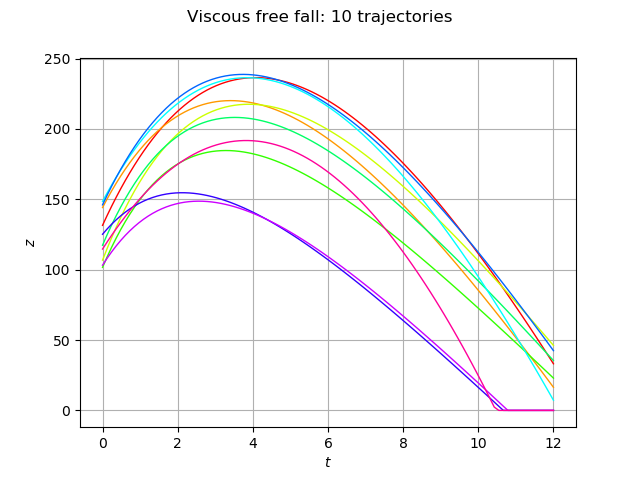

In [10]:
# Draw some curves
graph = outputSample.drawMarginal(0)
graph.setTitle('Viscous free fall: %d trajectories' % (size))
graph.setXTitle(r'$t$')
graph.setYTitle(r'$z$')
graph

We see that the object first go upwards, then falls down. Not all objects, however, achieve the same maximum altitude. We see that some of the trajectories have a larger maximum altitude while some other have a lower one. Moreover, at the final time $t_{max}$, one trajectory hits the ground so that $z(t_{max})=0$ for this trajectory. 